In [1]:
import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
import cv2 as cv
from tqdm.notebook import tqdm, trange
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
from os import walk
import datetime
import math

from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D , Flatten, Activation , Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l2

# Data PreProcessing

In [2]:
train_dir = "./dataset/train/"
test_dir="./dataset/test/"

translateDict = {"freshapples":["fresh","apple"],
                 "freshbanana":["fresh","banana"],
                 "freshoranges":["fresh","orange"],
                 "rottenapples":["rotten","apple"],
                 "rottenbanana":["rotten","banana"],
                 "rottenoranges":["rotten","orange"],
                }

trainPathList = pd.DataFrame(columns = ['filePath', 'fileName', 'class', 'fresh', 'combineClass'])
testPathList = pd.DataFrame(columns = ['filePath', 'fileName', 'class', 'fresh', 'combineClass'])

dirpath, dirnames, filenames = next(walk(train_dir), ([], [], []))
for folder in tqdm(dirnames):
    dirPathSub, dirNamesSub, fileNamesSub = next(walk(f'{dirpath}{folder}'), ([], [], []))
    for file in tqdm(fileNamesSub):
        tempDF = {"filePath": f'{dirpath}{folder}/{file}',"fileName": file, "class": translateDict[folder][1], "fresh":translateDict[folder][0], "combineClass":folder}
        trainPathList = trainPathList.append(tempDF, ignore_index=True)
        
    
dirpath, dirnames, filenames = next(walk(test_dir), ([], [], []))
for folder in tqdm(dirnames):
    dirPathSub, dirNamesSub, fileNamesSub = next(walk(f'{dirpath}{folder}'), ([], [], []))
    for file in tqdm(fileNamesSub):
        tempDF = {"filePath": f'{dirpath}{folder}/{file}',"fileName": file, "class": translateDict[folder][1], "fresh":translateDict[folder][0], "combineClass":folder}
        testPathList = testPathList.append(tempDF, ignore_index=True)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1693 [00:00<?, ?it/s]

  0%|          | 0/1601 [00:00<?, ?it/s]

  0%|          | 0/1466 [00:00<?, ?it/s]

  0%|          | 0/2342 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

  0%|          | 0/1595 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/381 [00:00<?, ?it/s]

  0%|          | 0/388 [00:00<?, ?it/s]

  0%|          | 0/601 [00:00<?, ?it/s]

  0%|          | 0/530 [00:00<?, ?it/s]

  0%|          | 0/403 [00:00<?, ?it/s]

In [3]:
trainPathList.to_csv('trainPathList.csv', index = False)
testPathList.to_csv('testPathList.csv', index = False)

In [4]:
trainPathDf = pd.read_csv('trainPathList.csv')
testPathDf = pd.read_csv('testPathList.csv')
image_size = (224, 224)

In [5]:
trainPathDf

,filePath,fileName,class,fresh,combineClass
0,./dataset/train/freshapples/rotated_by_15_Scre...,rotated_by_15_Screen Shot 2018-06-08 at 4.59.3...,apple,fresh,freshapples
1,./dataset/train/freshapples/rotated_by_15_Scre...,rotated_by_15_Screen Shot 2018-06-08 at 4.59.4...,apple,fresh,freshapples
2,./dataset/train/freshapples/rotated_by_15_Scre...,rotated_by_15_Screen Shot 2018-06-08 at 4.59.5...,apple,fresh,freshapples
3,./dataset/train/freshapples/rotated_by_15_Scre...,rotated_by_15_Screen Shot 2018-06-08 at 5.00.0...,apple,fresh,freshapples
4,./dataset/train/freshapples/rotated_by_15_Scre...,rotated_by_15_Screen Shot 2018-06-08 at 5.00.1...,apple,fresh,freshapples
...,...,...,...,...,...
10916,./dataset/train/rottenoranges/vertical_flip_Sc...,vertical_flip_Screen Shot 2018-06-12 at 11.46....,orange,rotten,rottenoranges
10917,./dataset/train/rottenoranges/vertical_flip_Sc...,vertical_flip_Screen Shot 2018-06-12 at 11.46....,orange,rotten,rottenoranges
10918,./dataset/train/rottenoranges/vertical_flip_Sc...,vertical_flip_Screen Shot 2018-06-12 at 11.46....,orange,rotten,rottenoranges
10919,./dataset/train/rottenoranges/vertical_flip_Sc...,vertical_flip_Screen Shot 2018-06-12 at 11.46....,orange,rotten,rottenoranges


In [6]:
def plotImgs(imgs, imgSize=(15, 10)):
    rowNum = math.ceil(len(imgs)/5)
    fig, ax = plt.subplots(figsize=imgSize)
    for plotI, img in enumerate(imgs):
        plt.subplot(rowNum, 5, plotI+1)
        plt.title('Image {}'.format(plotI))
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

def plotHistory(history, model, test_ds):
    plt.figure(figsize=(10, 10))
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="test loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_ylabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss eval")
    plt.tight_layout()
    plt.show()
    
    modelLoss, modelAcc = model.evaluate(test_ds, verbose=0)
    print(f"Accuracy on test: {modelAcc} with loss: {modelLoss}")
    
    
def augment_image(x):
    x = tf.image.random_saturation(x, 0.9, 1.2)
    x = tf.image.random_hue(x, 0.02)
    x = tf.image.random_contrast(x,lower=0.8,upper=3)
    x = tf.image.random_brightness(x,0.3)
    x = tf.image.random_flip_left_right(x)
    return x
    
def buildCnnModel(outputShape):
    
    outActivation = 'sigmoid' if outputShape == 1 else 'softmax'
    
    classifier = Sequential()
    
    classifier.add(Conv2D(filters=16, kernel_size=(5, 5),input_shape=(224, 224, 3), activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    classifier.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(Dropout(0.2))
    classifier.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
    classifier.add(BatchNormalization())

    classifier.add(Flatten())
    classifier.add(Dense(units=1024, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    
    classifier.add(Dense(units=512, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    
    classifier.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))
    classifier.add(Dropout(0.2))
    classifier.add(BatchNormalization())
    
    classifier.add(Dense(units=outputShape, activation=outActivation))
    return classifier

def buildMbNetModel(outputShape):
    
    outActivation = 'sigmoid' if outputShape == 1 else 'softmax'
    
    MobileNetBase = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    for layer in MobileNetBase.layers:
        layer.trainable = False

    x = Flatten()(MobileNetBase.output)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    x = Dense(outputShape, activation=outActivation)(x)
    MbNetModel = tf.keras.models.Model(MobileNetBase.input, x)
    return MbNetModel

callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_graph=True, write_grads=False, write_images=True,
    embeddings_freq=0, embeddings_layer_names=None,
    embeddings_metadata=None, embeddings_data=None, update_freq=500
)

train_dataDir = ""
test_dataDir = ""

In [7]:
train_datagen = image.ImageDataGenerator(
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function= augment_image
)

test_datagen = image.ImageDataGenerator(rescale=1/255)

# Multi Fruit Fresh Classifier

## Convolutional Neural Network

In [8]:
freshTrain_ds = train_datagen.flow_from_dataframe(trainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )

freshTest_ds = test_datagen.flow_from_dataframe(testPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )
freshTrain_ds.class_indices

Found 10921 non-validated image filenames belonging to 2 classes.
Found 2698 non-validated image filenames belonging to 2 classes.


{'fresh': 0, 'rotten': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


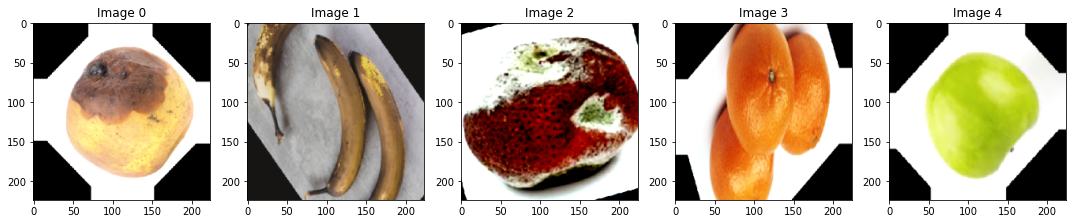

In [9]:
sample_training_images, _ = next(freshTrain_ds)
plotImgs(sample_training_images[:5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


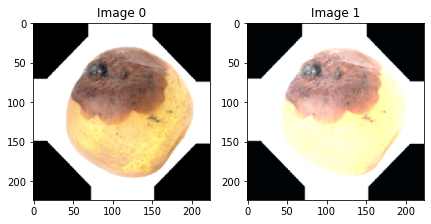

In [10]:
showCaseImg = sample_training_images[0]
augmented_showCaseImg = augment_image(showCaseImg)
plotImgs([showCaseImg, augmented_showCaseImg])

In [11]:
fullFreshCnn = buildCnnModel(1)
fullFreshCnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 53, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        5

In [12]:
fullFreshCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\fullFreshCnn.hdf5'
fullFreshCheckpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    mode="auto",
    save_best_only=True)

In [13]:
fullFreshHistory = fullFreshCnn.fit(freshTrain_ds, epochs=150, batch_size=50, callbacks=[callback, fullFreshCheckpoint, tensorboard_callback], validation_data=freshTest_ds)

Epoch 1/150
342/342 [==============================] - 157s 446ms/step - loss: 27.7063 - accuracy: 0.7957 - val_loss: 18.8480 - val_accuracy: 0.4333

Epoch 00001: val_loss improved from inf to 18.84800, saving model to .\checkpoint\fullFreshCnn.hdf5
Epoch 2/150
342/342 [==============================] - 150s 439ms/step - loss: 13.5571 - accuracy: 0.8925 - val_loss: 7.5741 - val_accuracy: 0.9003

Epoch 00002: val_loss improved from 18.84800 to 7.57414, saving model to .\checkpoint\fullFreshCnn.hdf5
Epoch 3/150
342/342 [==============================] - 150s 439ms/step - loss: 6.4922 - accuracy: 0.9102 - val_loss: 4.3886 - val_accuracy: 0.7936

Epoch 00003: val_loss improved from 7.57414 to 4.38856, saving model to .\checkpoint\fullFreshCnn.hdf5
Epoch 4/150
342/342 [==============================] - 150s 440ms/step - loss: 3.7983 - accuracy: 0.9170 - val_loss: 2.8081 - val_accuracy: 0.9351

Epoch 00004: val_loss improved from 4.38856 to 2.80813, saving model to .\checkpoint\fullFreshCnn.

Run ```tensorboard --logdir=.\logs``` in CMD and open the following link

http://localhost:6006/

In [14]:
fullFreshCnn.load_weights(checkpoint_filepath)

<Figure size 720x720 with 0 Axes>

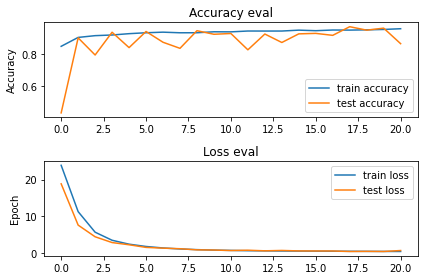

Accuracy on test: 0.9696071147918701 with loss: 0.3688082695007324


In [16]:
plotHistory(fullFreshHistory,fullFreshCnn,freshTest_ds)

In [17]:
fullFreshCnn.save('models/fullFreshCnn.h5')

In [18]:
#fullFreshCnn = tf.keras.models.load_model('models/fullFreshCnn')

## MobileNetV2

In [19]:
fullFreshMbNet = buildMbNetModel(1)
fullFreshMbNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [20]:
fullFreshMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\fullFreshMbNet.hdf5'
fullFreshMbCheckpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    mode="auto",
    save_best_only=True)

In [21]:
fullFreshMbHistory = fullFreshMbNet.fit(freshTrain_ds, validation_data=freshTest_ds, epochs=150, batch_size=50, callbacks=[
                                        callback, fullFreshMbCheckpoint, tensorboard_callback])

Epoch 1/150
342/342 [==============================] - 157s 448ms/step - loss: 20.7074 - accuracy: 0.9192 - val_loss: 6.9858 - val_accuracy: 0.9752

Epoch 00001: val_loss improved from inf to 6.98582, saving model to .\checkpoint\fullFreshMbNet.hdf5
Epoch 2/150
342/342 [==============================] - 145s 423ms/step - loss: 5.8150 - accuracy: 0.9605 - val_loss: 3.3498 - val_accuracy: 0.9711

Epoch 00002: val_loss improved from 6.98582 to 3.34980, saving model to .\checkpoint\fullFreshMbNet.hdf5
Epoch 3/150
342/342 [==============================] - 145s 424ms/step - loss: 2.8887 - accuracy: 0.9712 - val_loss: 1.9587 - val_accuracy: 0.9678

Epoch 00003: val_loss improved from 3.34980 to 1.95867, saving model to .\checkpoint\fullFreshMbNet.hdf5
Epoch 4/150
342/342 [==============================] - 145s 424ms/step - loss: 1.7760 - accuracy: 0.9694 - val_loss: 1.3113 - val_accuracy: 0.9759

Epoch 00004: val_loss improved from 1.95867 to 1.31129, saving model to .\checkpoint\fullFreshMb

In [22]:
fullFreshMbNet.load_weights(checkpoint_filepath)

<Figure size 720x720 with 0 Axes>

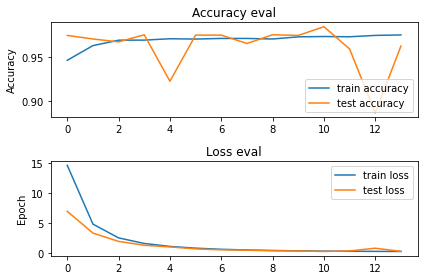

Accuracy on test: 0.9851741790771484 with loss: 0.2695011794567108


In [24]:
plotHistory(fullFreshMbHistory, fullFreshMbNet, freshTest_ds)

In [25]:
fullFreshMbNet.save('models/fullFreshMbNet.h5')

# Single Fruit Fresh Classifier

## Apple

In [26]:
appleTrainPathDf = trainPathDf[trainPathDf["class"] == "apple"]
appleTestPathDf = testPathDf[testPathDf["class"] == "apple"]

appleFreshTrain_ds = train_datagen.flow_from_dataframe(appleTrainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )

appleFreshTest_ds = test_datagen.flow_from_dataframe(appleTestPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )
appleFreshTrain_ds.class_indices

Found 4035 non-validated image filenames belonging to 2 classes.
Found 996 non-validated image filenames belonging to 2 classes.


{'fresh': 0, 'rotten': 1}

### Convolutional Neural Network

In [27]:
appleFreshCnn = buildCnnModel(1)

appleFreshCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\appleFreshCnn.hdf5'
appleFreshCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

appleFreshCnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 49, 49, 64)       

In [28]:
appleFreshHistory = appleFreshCnn.fit(appleFreshTrain_ds, epochs=150, batch_size=50, callbacks=[callback, appleFreshCheckpoint, tensorboard_callback], validation_data=appleFreshTest_ds)

Epoch 1/150
127/127 [==============================] - 60s 455ms/step - loss: 29.7377 - accuracy: 0.8151 - val_loss: 26.4085 - val_accuracy: 0.3966

Epoch 00001: val_loss improved from inf to 26.40847, saving model to .\checkpoint\appleFreshCnn.hdf5
Epoch 2/150
127/127 [==============================] - 53s 419ms/step - loss: 22.6888 - accuracy: 0.9055 - val_loss: 20.9111 - val_accuracy: 0.3966

Epoch 00002: val_loss improved from 26.40847 to 20.91106, saving model to .\checkpoint\appleFreshCnn.hdf5
Epoch 3/150
127/127 [==============================] - 53s 415ms/step - loss: 16.5337 - accuracy: 0.9062 - val_loss: 13.8268 - val_accuracy: 0.4618

Epoch 00003: val_loss improved from 20.91106 to 13.82682, saving model to .\checkpoint\appleFreshCnn.hdf5
Epoch 4/150
127/127 [==============================] - 53s 414ms/step - loss: 12.0663 - accuracy: 0.9171 - val_loss: 9.7396 - val_accuracy: 0.8855

Epoch 00004: val_loss improved from 13.82682 to 9.73956, saving model to .\checkpoint\appleF

<Figure size 720x720 with 0 Axes>

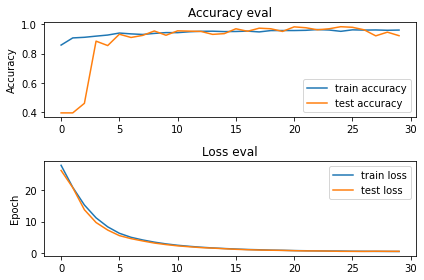

Accuracy on test: 0.9628514051437378 with loss: 0.4880671799182892


In [29]:
appleFreshCnn.load_weights(checkpoint_filepath)
plotHistory(appleFreshHistory, appleFreshCnn, appleFreshTest_ds)
appleFreshCnn.save('models/appleFreshCnn.h5')

### MobileNetV2

In [30]:
appleFreshMbNet = buildMbNetModel(1)

appleFreshMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\appleFreshMbNet.hdf5'
appleFreshMbCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

appleFreshMbNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [31]:
appleFreshMbNetHistory = appleFreshMbNet.fit(appleFreshTrain_ds, validation_data=appleFreshTest_ds, epochs=150, batch_size=50, callbacks=[
                                             callback, appleFreshMbCheckpoint, tensorboard_callback])

Epoch 1/150
127/127 [==============================] - 66s 492ms/step - loss: 24.4545 - accuracy: 0.9163 - val_loss: 13.8053 - val_accuracy: 0.9347

Epoch 00001: val_loss improved from inf to 13.80534, saving model to .\checkpoint\appleFreshMbNet.hdf5
Epoch 2/150
127/127 [==============================] - 58s 455ms/step - loss: 12.0214 - accuracy: 0.9669 - val_loss: 8.2517 - val_accuracy: 0.9799

Epoch 00002: val_loss improved from 13.80534 to 8.25175, saving model to .\checkpoint\appleFreshMbNet.hdf5
Epoch 3/150
127/127 [==============================] - 59s 461ms/step - loss: 7.5554 - accuracy: 0.9747 - val_loss: 5.7282 - val_accuracy: 0.9729

Epoch 00003: val_loss improved from 8.25175 to 5.72822, saving model to .\checkpoint\appleFreshMbNet.hdf5
Epoch 4/150
127/127 [==============================] - 59s 461ms/step - loss: 5.2540 - accuracy: 0.9811 - val_loss: 4.1343 - val_accuracy: 0.9839

Epoch 00004: val_loss improved from 5.72822 to 4.13430, saving model to .\checkpoint\appleFre

Epoch 35/150
127/127 [==============================] - 52s 413ms/step - loss: 0.2066 - accuracy: 0.9891 - val_loss: 0.1907 - val_accuracy: 0.9890

Epoch 00035: val_loss improved from 0.20062 to 0.19068, saving model to .\checkpoint\appleFreshMbNet.hdf5
Epoch 36/150
127/127 [==============================] - 53s 414ms/step - loss: 0.2133 - accuracy: 0.9854 - val_loss: 0.2106 - val_accuracy: 0.9869

Epoch 00036: val_loss did not improve from 0.19068
Epoch 37/150
127/127 [==============================] - 53s 414ms/step - loss: 0.2278 - accuracy: 0.9802 - val_loss: 0.2254 - val_accuracy: 0.9900

Epoch 00037: val_loss did not improve from 0.19068
Epoch 38/150
127/127 [==============================] - 53s 414ms/step - loss: 0.2290 - accuracy: 0.9830 - val_loss: 0.1970 - val_accuracy: 0.9890

Epoch 00038: val_loss did not improve from 0.19068
Epoch 00038: early stopping


<Figure size 720x720 with 0 Axes>

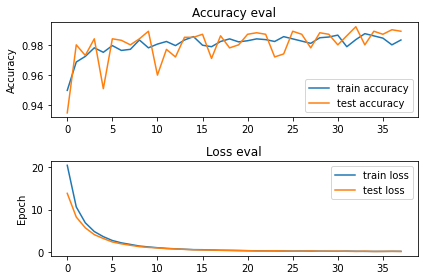

Accuracy on test: 0.9889557957649231 with loss: 0.19067944586277008


In [32]:
appleFreshMbNet.load_weights(checkpoint_filepath)
plotHistory(appleFreshMbNetHistory, appleFreshMbNet, appleFreshTest_ds)
appleFreshMbNet.save('models/appleFreshMbNet.h5')

## Banana

In [33]:
bananaTrainPathDf = trainPathDf[trainPathDf["class"] == "banana"]
bananaTestPathDf = testPathDf[testPathDf["class"] == "banana"]

bananaFreshTrain_ds = train_datagen.flow_from_dataframe(bananaTrainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )

bananaFreshTest_ds = test_datagen.flow_from_dataframe(bananaTestPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )
bananaFreshTrain_ds.class_indices

Found 3825 non-validated image filenames belonging to 2 classes.
Found 911 non-validated image filenames belonging to 2 classes.


{'fresh': 0, 'rotten': 1}

### Convolutional Neural Network

In [34]:
bananaFreshCnn = buildCnnModel(1)

bananaFreshCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\bananaFreshCnn.hdf5'
bananaFreshCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

#bananaFreshCnn.summary()

In [35]:
bananaFreshHistory = bananaFreshCnn.fit(bananaFreshTrain_ds, validation_data=bananaFreshTest_ds, epochs=150, batch_size=50, callbacks=[
                                        callback, bananaFreshCheckpoint, tensorboard_callback])

Epoch 1/150
120/120 [==============================] - 60s 488ms/step - loss: 28.9826 - accuracy: 0.9166 - val_loss: 22.0470 - val_accuracy: 0.5818

Epoch 00001: val_loss improved from inf to 22.04704, saving model to .\checkpoint\bananaFreshCnn.hdf5
Epoch 2/150
120/120 [==============================] - 52s 434ms/step - loss: 19.1588 - accuracy: 0.9733 - val_loss: 13.2992 - val_accuracy: 0.7805

Epoch 00002: val_loss improved from 22.04704 to 13.29921, saving model to .\checkpoint\bananaFreshCnn.hdf5
Epoch 3/150
120/120 [==============================] - 51s 428ms/step - loss: 11.6801 - accuracy: 0.9734 - val_loss: 8.1385 - val_accuracy: 0.9835

Epoch 00003: val_loss improved from 13.29921 to 8.13854, saving model to .\checkpoint\bananaFreshCnn.hdf5
Epoch 4/150
120/120 [==============================] - 51s 427ms/step - loss: 7.1793 - accuracy: 0.9850 - val_loss: 5.1666 - val_accuracy: 0.9868

Epoch 00004: val_loss improved from 8.13854 to 5.16658, saving model to .\checkpoint\bananaF

<Figure size 720x720 with 0 Axes>

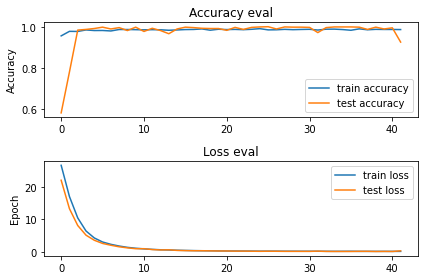

Accuracy on test: 0.997804582118988 with loss: 0.14990371465682983


In [36]:
bananaFreshCnn.load_weights(checkpoint_filepath)
plotHistory(bananaFreshHistory, bananaFreshCnn, bananaFreshTest_ds)
bananaFreshCnn.save('models/bananaFreshCnn.h5')

### MobileNetV2

In [37]:
bananaFreshMbNet = buildMbNetModel(1)

bananaFreshMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\bananaFreshMbNet.hdf5'
bananaFreshMbCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

#bananaFreshMbNet.summary()

In [38]:
bananaFreshMbHistory = bananaFreshMbNet.fit(bananaFreshTrain_ds, epochs=150, batch_size=50, callbacks=[
                                        callback, bananaFreshMbCheckpoint, tensorboard_callback], validation_data=bananaFreshTest_ds)

Epoch 1/150
120/120 [==============================] - 71s 558ms/step - loss: 24.2447 - accuracy: 0.9538 - val_loss: 11.3510 - val_accuracy: 0.9934

Epoch 00001: val_loss improved from inf to 11.35096, saving model to .\checkpoint\bananaFreshMbNet.hdf5
Epoch 2/150
120/120 [==============================] - 60s 501ms/step - loss: 9.3360 - accuracy: 0.9921 - val_loss: 5.2789 - val_accuracy: 0.9989

Epoch 00002: val_loss improved from 11.35096 to 5.27890, saving model to .\checkpoint\bananaFreshMbNet.hdf5
Epoch 3/150
120/120 [==============================] - 60s 498ms/step - loss: 4.6595 - accuracy: 0.9916 - val_loss: 3.3307 - val_accuracy: 0.9759

Epoch 00003: val_loss improved from 5.27890 to 3.33070, saving model to .\checkpoint\bananaFreshMbNet.hdf5
Epoch 4/150
120/120 [==============================] - 59s 496ms/step - loss: 2.9165 - accuracy: 0.9942 - val_loss: 2.1427 - val_accuracy: 0.9912

Epoch 00004: val_loss improved from 3.33070 to 2.14265, saving model to .\checkpoint\banana

<Figure size 720x720 with 0 Axes>

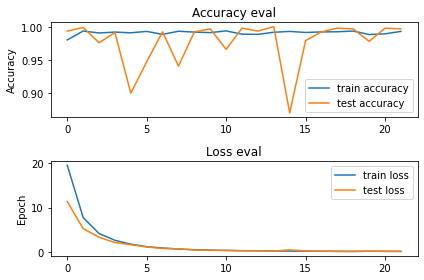

Accuracy on test: 0.9967069029808044 with loss: 0.1379280835390091


In [39]:
bananaFreshMbNet.load_weights(checkpoint_filepath)
plotHistory(bananaFreshMbHistory, bananaFreshMbNet, bananaFreshTest_ds)

In [40]:
bananaFreshMbNet.save('models/bananaFreshMbNet.h5')

## orange

In [41]:
orangeTrainPathDf = trainPathDf[trainPathDf["class"] == "orange"]
orangeTestPathDf = testPathDf[testPathDf["class"] == "orange"]

orangeFreshTrain_ds = train_datagen.flow_from_dataframe(orangeTrainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )

orangeFreshTest_ds = test_datagen.flow_from_dataframe(orangeTestPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='fresh',
                                             class_mode='binary',
                                             validate_filenames=False,
                                             )
orangeFreshTrain_ds.class_indices

Found 3061 non-validated image filenames belonging to 2 classes.
Found 791 non-validated image filenames belonging to 2 classes.


{'fresh': 0, 'rotten': 1}

### Convolutional Neural Network

In [42]:
orangeFreshCnn = buildCnnModel(1)

orangeFreshCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\orangeFreshCnn.hdf5'
orangeFreshCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

#orangeFreshCnn.summary()

In [43]:
orangeFreshHistory = orangeFreshCnn.fit(orangeFreshTrain_ds, epochs=150, batch_size=50, callbacks=[callback, orangeFreshCheckpoint, tensorboard_callback], validation_data=orangeFreshTest_ds)

Epoch 1/150
96/96 [==============================] - 50s 497ms/step - loss: 30.0808 - accuracy: 0.7986 - val_loss: 27.4884 - val_accuracy: 0.5095

Epoch 00001: val_loss improved from inf to 27.48841, saving model to .\checkpoint\orangeFreshCnn.hdf5
Epoch 2/150
96/96 [==============================] - 39s 408ms/step - loss: 25.3568 - accuracy: 0.8856 - val_loss: 22.7653 - val_accuracy: 0.5095

Epoch 00002: val_loss improved from 27.48841 to 22.76531, saving model to .\checkpoint\orangeFreshCnn.hdf5
Epoch 3/150
96/96 [==============================] - 39s 410ms/step - loss: 20.5044 - accuracy: 0.9073 - val_loss: 18.2798 - val_accuracy: 0.5095

Epoch 00003: val_loss improved from 22.76531 to 18.27979, saving model to .\checkpoint\orangeFreshCnn.hdf5
Epoch 4/150
96/96 [==============================] - 39s 409ms/step - loss: 16.0993 - accuracy: 0.9108 - val_loss: 13.4033 - val_accuracy: 0.9343

Epoch 00004: val_loss improved from 18.27979 to 13.40326, saving model to .\checkpoint\orangeFre

<Figure size 720x720 with 0 Axes>

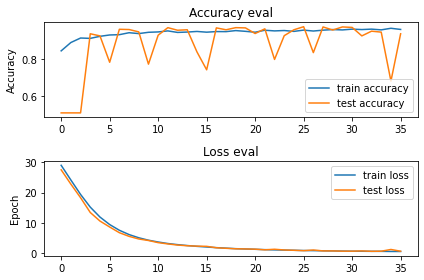

Accuracy on test: 0.9481669068336487 with loss: 0.5879531502723694


In [44]:
orangeFreshCnn.load_weights(checkpoint_filepath)
plotHistory(orangeFreshHistory, orangeFreshCnn, orangeFreshTest_ds)

In [45]:
orangeFreshCnn.save('models/orangeFreshCnn.h5')

### MobileNetV2

In [46]:
orangeFreshMbNet = buildMbNetModel(1)

orangeFreshMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\orangeFreshMbNet.hdf5'
orangeFreshMbCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

#orangeFreshCnn.summary()

In [47]:
orangeFreshMbHistory = orangeFreshMbNet.fit(orangeFreshTrain_ds, validation_data=orangeFreshTest_ds, epochs=150, batch_size=50, callbacks=[callback, orangeFreshMbCheckpoint, tensorboard_callback])

Epoch 1/150
96/96 [==============================] - 50s 489ms/step - loss: 25.8313 - accuracy: 0.8850 - val_loss: 16.6928 - val_accuracy: 0.9899

Epoch 00001: val_loss improved from inf to 16.69276, saving model to .\checkpoint\orangeFreshMbNet.hdf5
Epoch 2/150
96/96 [==============================] - 41s 432ms/step - loss: 14.7439 - accuracy: 0.9664 - val_loss: 10.1518 - val_accuracy: 0.9924

Epoch 00002: val_loss improved from 16.69276 to 10.15176, saving model to .\checkpoint\orangeFreshMbNet.hdf5
Epoch 3/150
96/96 [==============================] - 42s 434ms/step - loss: 9.2268 - accuracy: 0.9775 - val_loss: 7.0581 - val_accuracy: 0.9772

Epoch 00003: val_loss improved from 10.15176 to 7.05809, saving model to .\checkpoint\orangeFreshMbNet.hdf5
Epoch 4/150
96/96 [==============================] - 41s 432ms/step - loss: 6.5659 - accuracy: 0.9726 - val_loss: 5.4081 - val_accuracy: 0.9583

Epoch 00004: val_loss improved from 7.05809 to 5.40806, saving model to .\checkpoint\orangeFres


Epoch 00034: val_loss did not improve from 0.26604
Epoch 35/150
96/96 [==============================] - 42s 435ms/step - loss: 0.2687 - accuracy: 0.9865 - val_loss: 0.2336 - val_accuracy: 0.9924

Epoch 00035: val_loss improved from 0.26604 to 0.23355, saving model to .\checkpoint\orangeFreshMbNet.hdf5
Epoch 36/150
96/96 [==============================] - 42s 435ms/step - loss: 0.2783 - accuracy: 0.9804 - val_loss: 0.2522 - val_accuracy: 0.9912

Epoch 00036: val_loss did not improve from 0.23355
Epoch 37/150
96/96 [==============================] - 42s 437ms/step - loss: 0.2717 - accuracy: 0.9836 - val_loss: 0.4241 - val_accuracy: 0.9444

Epoch 00037: val_loss did not improve from 0.23355
Epoch 38/150
96/96 [==============================] - 42s 433ms/step - loss: 0.2814 - accuracy: 0.9799 - val_loss: 0.2852 - val_accuracy: 0.9747

Epoch 00038: val_loss did not improve from 0.23355
Epoch 00038: early stopping


<Figure size 720x720 with 0 Axes>

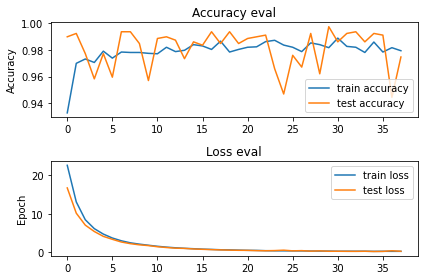

Accuracy on test: 0.992414653301239 with loss: 0.23355251550674438


In [49]:
orangeFreshMbNet.load_weights(checkpoint_filepath)
plotHistory(orangeFreshMbHistory, orangeFreshMbNet, orangeFreshTest_ds)

In [50]:
orangeFreshMbNet.save('models/orangeFreshMbNet.h5')

# Fruit Classifier

In [128]:
fruitTrain_ds = train_datagen.flow_from_dataframe(trainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='class',
                                             class_mode='categorical',
                                             validate_filenames=False,
                                             )

fruitTest_ds = test_datagen.flow_from_dataframe(testPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='class',
                                             class_mode='categorical',
                                             validate_filenames=False,
                                             )
fruitTrain_ds.class_indices

Found 10921 non-validated image filenames belonging to 3 classes.
Found 2698 non-validated image filenames belonging to 3 classes.


{'apple': 0, 'banana': 1, 'orange': 2}

## Convolutional Neural Network

In [52]:
fruitCnn = buildCnnModel(3)

fruitCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
    
checkpoint_filepath = '.\\checkpoint\\fruitCnn.hdf5'
fruitCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

fruitCnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 49, 49, 64)       

In [53]:
fruitCnnHistory = fruitCnn.fit(fruitTrain_ds, epochs=150, batch_size=50, callbacks=[callback, fruitCheckpoint, tensorboard_callback], validation_data=fruitTest_ds)

Epoch 1/150
342/342 [==============================] - 156s 451ms/step - loss: 29.2539 - accuracy: 0.7403 - val_loss: 21.1385 - val_accuracy: 0.5352

Epoch 00001: val_loss improved from inf to 21.13854, saving model to .\checkpoint\fruitCnn.hdf5
Epoch 2/150
342/342 [==============================] - 146s 427ms/step - loss: 17.7823 - accuracy: 0.8855 - val_loss: 11.2074 - val_accuracy: 0.9151

Epoch 00002: val_loss improved from 21.13854 to 11.20735, saving model to .\checkpoint\fruitCnn.hdf5
Epoch 3/150
342/342 [==============================] - 146s 427ms/step - loss: 9.7465 - accuracy: 0.9030 - val_loss: 6.5125 - val_accuracy: 0.9066

Epoch 00003: val_loss improved from 11.20735 to 6.51248, saving model to .\checkpoint\fruitCnn.hdf5
Epoch 4/150
342/342 [==============================] - 145s 423ms/step - loss: 5.7834 - accuracy: 0.9193 - val_loss: 4.2806 - val_accuracy: 0.8892

Epoch 00004: val_loss improved from 6.51248 to 4.28057, saving model to .\checkpoint\fruitCnn.hdf5
Epoch 5/

Epoch 36/150
342/342 [==============================] - 145s 423ms/step - loss: 0.3339 - accuracy: 0.9640 - val_loss: 0.4374 - val_accuracy: 0.9292

Epoch 00036: val_loss did not improve from 0.31132
Epoch 37/150
342/342 [==============================] - 143s 418ms/step - loss: 0.3496 - accuracy: 0.9607 - val_loss: 0.4318 - val_accuracy: 0.9129

Epoch 00037: val_loss did not improve from 0.31132
Epoch 00037: early stopping


<Figure size 720x720 with 0 Axes>

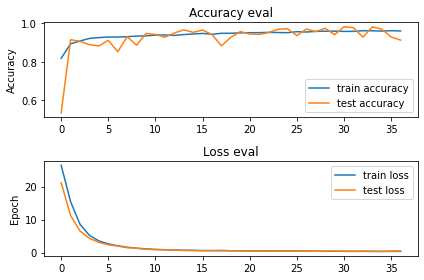

Accuracy on test: 0.9814677834510803 with loss: 0.3113238513469696


In [54]:
fruitCnn.load_weights(checkpoint_filepath)
plotHistory(fruitCnnHistory, fruitCnn, fruitTest_ds)

In [55]:
fruitCnn.save('models/fruitCnn.h5')

## MobileNetV2

In [56]:
fruitMbNet = buildMbNetModel(3)

fruitMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
    
checkpoint_filepath = '.\\checkpoint\\fruitMbNet.hdf5'
fruitMbCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

fruitMbNet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [57]:
fruitMbHistory = fruitMbNet.fit(fruitTrain_ds, validation_data=fruitTest_ds, epochs=150, batch_size=50, callbacks=[callback, fruitMbCheckpoint, tensorboard_callback])

Epoch 1/150
342/342 [==============================] - 165s 469ms/step - loss: 21.3481 - accuracy: 0.9232 - val_loss: 7.0873 - val_accuracy: 0.9896

Epoch 00001: val_loss improved from inf to 7.08726, saving model to .\checkpoint\fruitMbNet.hdf5
Epoch 2/150
342/342 [==============================] - 153s 447ms/step - loss: 5.8099 - accuracy: 0.9770 - val_loss: 3.3426 - val_accuracy: 0.9874

Epoch 00002: val_loss improved from 7.08726 to 3.34257, saving model to .\checkpoint\fruitMbNet.hdf5
Epoch 3/150
342/342 [==============================] - 152s 444ms/step - loss: 2.9381 - accuracy: 0.9773 - val_loss: 2.0180 - val_accuracy: 0.9774

Epoch 00003: val_loss improved from 3.34257 to 2.01797, saving model to .\checkpoint\fruitMbNet.hdf5
Epoch 4/150
342/342 [==============================] - 154s 451ms/step - loss: 1.8129 - accuracy: 0.9781 - val_loss: 1.6638 - val_accuracy: 0.8603

Epoch 00004: val_loss improved from 2.01797 to 1.66377, saving model to .\checkpoint\fruitMbNet.hdf5
Epoch 5

<Figure size 720x720 with 0 Axes>

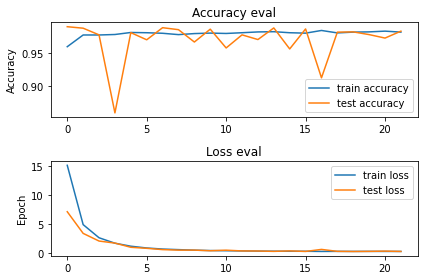

Accuracy on test: 0.9818384051322937 with loss: 0.2117834836244583


In [58]:
fruitMbNet.load_weights(checkpoint_filepath)
plotHistory(fruitMbHistory, fruitMbNet, fruitTest_ds)

In [59]:
fruitMbNet.save('models/fruitMbNet.h5')

# Combine Class Classifier

In [60]:
combineClassTrain_ds = train_datagen.flow_from_dataframe(trainPathDf,
                                             directory=train_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='combineClass',
                                             class_mode='categorical',
                                             validate_filenames=False,
                                             )

combineClassTest_ds = test_datagen.flow_from_dataframe(testPathDf,
                                             directory=test_dataDir,
                                             target_size=image_size,
                                             batch_size=32,
                                             x_col='filePath',
                                             y_col='combineClass',
                                             class_mode='categorical',
                                             validate_filenames=False,
                                             )
combineClassTrain_ds.class_indices

Found 10921 non-validated image filenames belonging to 6 classes.
Found 2698 non-validated image filenames belonging to 6 classes.


{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

## Convolutional Neural Network

In [212]:
combineClassCnn = buildCnnModel(6)

combineClassCnn.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\combineClassCnn.hdf5'
combineClassCnnCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [213]:
combineClassCnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 220, 220, 16)      1216      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 110, 110, 16)      0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 110, 110, 16)      64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 106, 106, 32)      12832     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 53, 53, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 49, 49, 64)       

In [65]:
combineClassCnnHistory = combineClassCnn.fit(combineClassTrain_ds, validation_data=combineClassTest_ds, epochs=150, batch_size=50, callbacks=[
                                              callback, combineClassCnnCheckpoint, tensorboard_callback])

Epoch 1/150
342/342 [==============================] - 163s 466ms/step - loss: 22.6587 - accuracy: 0.8544 - val_loss: 9.1088 - val_accuracy: 0.9585

Epoch 00001: val_loss improved from inf to 9.10884, saving model to .\checkpoint\combineClassCnn.hdf5
Epoch 2/150
342/342 [==============================] - 152s 445ms/step - loss: 7.7321 - accuracy: 0.9523 - val_loss: 4.8405 - val_accuracy: 0.9637

Epoch 00002: val_loss improved from 9.10884 to 4.84051, saving model to .\checkpoint\combineClassCnn.hdf5
Epoch 3/150
342/342 [==============================] - 153s 447ms/step - loss: 4.3387 - accuracy: 0.9600 - val_loss: 3.1661 - val_accuracy: 0.9585

Epoch 00003: val_loss improved from 4.84051 to 3.16612, saving model to .\checkpoint\combineClassCnn.hdf5
Epoch 4/150
342/342 [==============================] - 152s 444ms/step - loss: 2.8918 - accuracy: 0.9617 - val_loss: 2.2264 - val_accuracy: 0.9548

Epoch 00004: val_loss improved from 3.16612 to 2.22638, saving model to .\checkpoint\combineC

<Figure size 720x720 with 0 Axes>

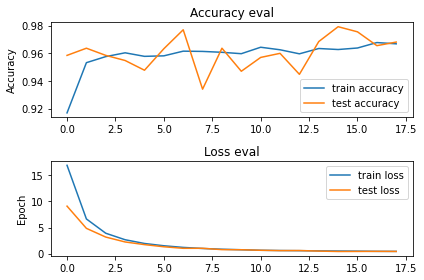

Accuracy on test: 0.9792438745498657 with loss: 0.3961470425128937


In [66]:
combineClassCnn.load_weights(checkpoint_filepath)
plotHistory(combineClassCnnHistory, combineClassCnn, combineClassTest_ds)

In [67]:
combineClassCnn.save('models/combineClassCnn.h5')

## MobileNetV2

In [68]:
combineClassMbNet = buildMbNetModel(6)

combineClassMbNet.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

checkpoint_filepath = '.\\checkpoint\\combineClassMbNet.hdf5'
combineClassMbNetCheckpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

In [69]:
combineClassMbHistory = combineClassMbNet.fit(combineClassTrain_ds, validation_data=combineClassTest_ds, epochs=150, batch_size=50, callbacks=[
                                              callback, combineClassMbNetCheckpoint, tensorboard_callback])

Epoch 1/150
342/342 [==============================] - 165s 473ms/step - loss: 22.6271 - accuracy: 0.8716 - val_loss: 9.2845 - val_accuracy: 0.9581

Epoch 00001: val_loss improved from inf to 9.28455, saving model to .\checkpoint\combineClassMbNet.hdf5
Epoch 2/150
342/342 [==============================] - 152s 445ms/step - loss: 7.8940 - accuracy: 0.9474 - val_loss: 5.0265 - val_accuracy: 0.9715

Epoch 00002: val_loss improved from 9.28455 to 5.02648, saving model to .\checkpoint\combineClassMbNet.hdf5
Epoch 3/150
342/342 [==============================] - 147s 429ms/step - loss: 4.4664 - accuracy: 0.9636 - val_loss: 3.1770 - val_accuracy: 0.9666

Epoch 00003: val_loss improved from 5.02648 to 3.17697, saving model to .\checkpoint\combineClassMbNet.hdf5
Epoch 4/150
342/342 [==============================] - 147s 430ms/step - loss: 2.9416 - accuracy: 0.9576 - val_loss: 2.2544 - val_accuracy: 0.9711

Epoch 00004: val_loss improved from 3.17697 to 2.25437, saving model to .\checkpoint\co

<Figure size 720x720 with 0 Axes>

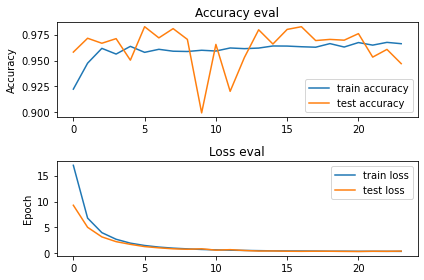

Accuracy on test: 0.975908100605011 with loss: 0.354831337928772


In [70]:
combineClassMbNet.load_weights(checkpoint_filepath)
plotHistory(combineClassMbHistory, combineClassMbNet, combineClassTest_ds)

In [71]:
combineClassMbNet.save('models/combineClassMbNet.h5')

## Prediction

In [214]:
def getSinglePredImgList(filePath):
    predImg = image.load_img(filePath, target_size=image_size)
    predImg = np.asanyarray(predImg)
    predImg = predImg/255
    predImg = np.expand_dims(predImg, axis=0)
    return predImg


def int2FreshLabel(classProb):
    predResult = 'rotten' if classProb == 1 else 'fresh'
    return predResult


def int2CCLabel(labelIndex):  # Combine Class Label
    CCdict = {
        0: ['apple', 'fresh'],
        1: ['banana', 'fresh'],
        2: ['orange', 'fresh'],
        3: ['apple', 'rotten'],
        4: ['banana', 'rotten'],
        5: ['orange', 'rotten'],
    }
    return CCdict[labelIndex]


def int2FruitLabel(labelIndex):  # Combine Class Label
    Fruitdict = {0: 'apple',
                 1: 'banana',
                 2: 'orange'}
    return Fruitdict[labelIndex]


def getCCPred(model, imgList):
    classIndex = np.argmax(model.predict(imgList))
    return int2CCLabel(classIndex)


def getFruitPred(model, imgList):
    classIndex = np.argmax(model.predict(imgList))
    return int2FruitLabel(classIndex)


def getFreshPred(model, imgList):
    classProb = (model.predict(imgList) > 0.5).astype("int32")
    return int2FreshLabel(classProb)

def CombineClassPredictor(predImgList):
    return getCCPred(combineClassMbNet, predImgList)

def ConditionalFlowPredictor(predImgList):
    predTag = []
    predFruitType = getFruitPred(fruitMbNet, predImgList)
    predTag.append(predFruitType)
    if predFruitType == "apple":
        predTag.append(getFreshPred(appleFreshMbNet, predImgList))
    elif predFruitType == "banana":
        predTag.append(getFreshPred(bananaFreshMbNet, predImgList))
    elif predFruitType == "orange":
        predTag.append(getFreshPred(orangeFreshMbNet, predImgList))
    return predTag

def SingleFlowPredictor(predImgList):
    predTag = []
    predTag.append(getFruitPred(fruitMbNet, predImgList))
    predTag.append(getFreshPred(fullFreshMbNet, predImgList))

    return predTag

# single Image Prediction

(1, 224, 224, 3)


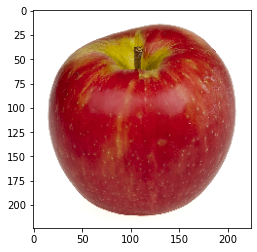

In [215]:
predImgPath = "./predTest/apple/fresh/Honeycrisp-Apple.jpg"
predImgList = getPredImgList(predImgPath)
print(predImgList.shape)
plt.imshow(predImgList[0])

In [216]:
CombineClassPredictor(predImgList)

['apple', 'fresh']

In [217]:
ConditionalFlowPredictor(predImgList)

['apple', 'fresh']

In [218]:
SingleFlowPredictor(predImgList)

['apple', 'fresh']

# Multi Image Prediction

In [219]:
def int2FruitLabel(fullCnnPred):
    predResult = []
    for pred in fullCnnPred:
        classIndex = np.argmax(pred)
        if classIndex == 0:
            predResult.append('apple')
        elif classIndex == 1:
            predResult.append('banana')
        elif classIndex == 2:
            predResult.append('orange')
    return np.array(predResult)

def plotPredImgs(Indexes, imgSize=(15, 30)):
    rowNum = math.ceil(len(Indexes)/5)
    fig, ax = plt.subplots(figsize=imgSize)
    for plotI, imgIndex in enumerate(Indexes):
        plt.subplot(rowNum, 5, plotI+1)
        plt.title('Image {}'.format(plotI))
        img_rgb = cv.cvtColor(cv.imread(testPathDf.iloc[imgIndex]["filePath"], -1), cv.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    plt.tight_layout()
    plt.show()
    
def printResult(predResult, testResult):
    for i, pred in enumerate(predResult):
        resultText = 'Correct' if pred == testResult[i] else 'Incorrect'
        print(f'img{i}\t[{resultText}]\t=> Predict: {pred}  \t|   Real: {testResult[i]}')

In [220]:
fileListLen = len(testPathDf)
print("File Num: ",fileListLen)
testPathDf.head()

File Num:  2698


,filePath,fileName,class,fresh,combineClass
0,./dataset/test/freshapples/rotated_by_15_Scree...,rotated_by_15_Screen Shot 2018-06-08 at 4.59.4...,apple,fresh,freshapples
1,./dataset/test/freshapples/rotated_by_15_Scree...,rotated_by_15_Screen Shot 2018-06-08 at 5.00.3...,apple,fresh,freshapples
2,./dataset/test/freshapples/rotated_by_15_Scree...,rotated_by_15_Screen Shot 2018-06-08 at 5.00.4...,apple,fresh,freshapples
3,./dataset/test/freshapples/rotated_by_15_Scree...,rotated_by_15_Screen Shot 2018-06-08 at 5.01.0...,apple,fresh,freshapples
4,./dataset/test/freshapples/rotated_by_15_Scree...,rotated_by_15_Screen Shot 2018-06-08 at 5.02.0...,apple,fresh,freshapples


In [221]:
testImgIndexes = []
testImgs = []
testResult = []

for i in trange(100):
    ranFileIndex = randint(0, fileListLen-1)
    
    tempFile = image.load_img(testPathDf.iloc[ranFileIndex]["filePath"], target_size = image_size)
    tempFile = np.asanyarray(tempFile)

    testImgIndexes.append(ranFileIndex)
    testImgs.append(tempFile)
    tempResultTag = [testPathDf.iloc[ranFileIndex]["class"], testPathDf.iloc[ranFileIndex]["fresh"]]
    testResult.append(tempResultTag)
testImgIndexes = np.array(testImgIndexes)
testImgs = np.array(testImgs)
testImgs = testImgs/255

  0%|          | 0/100 [00:00<?, ?it/s]

In [222]:
testImgIndexes

array([1700, 1561, 1576, 1944, 1096, 2550,  863, 1739,  660, 1806, 1471,
       2640, 2592, 2490, 2564, 2190, 1657, 1517, 1906,  948, 1933, 1777,
       1525,  720, 1266, 1685, 2534, 1633, 1058,  838, 1237, 2024, 1701,
        282, 1290,  703,  925, 2178,  967, 2385, 1951,  563, 2074, 1539,
        269, 1087,  737, 2546, 1732,  746, 2579, 1519, 2022, 2644, 2057,
       2093, 1657,  787,  152, 2058, 2656,  135,  817, 2058, 1812,  133,
        245,  747,  922, 1131, 2390, 1910,  138, 2064,  139,  826,  154,
       2039,  349, 1510,  362,  523, 1319, 1694, 2206, 2161, 1855, 1293,
       1476, 1122, 1528,  456,  370, 2191,   68,  573, 1307, 2394, 1464,
       1647])

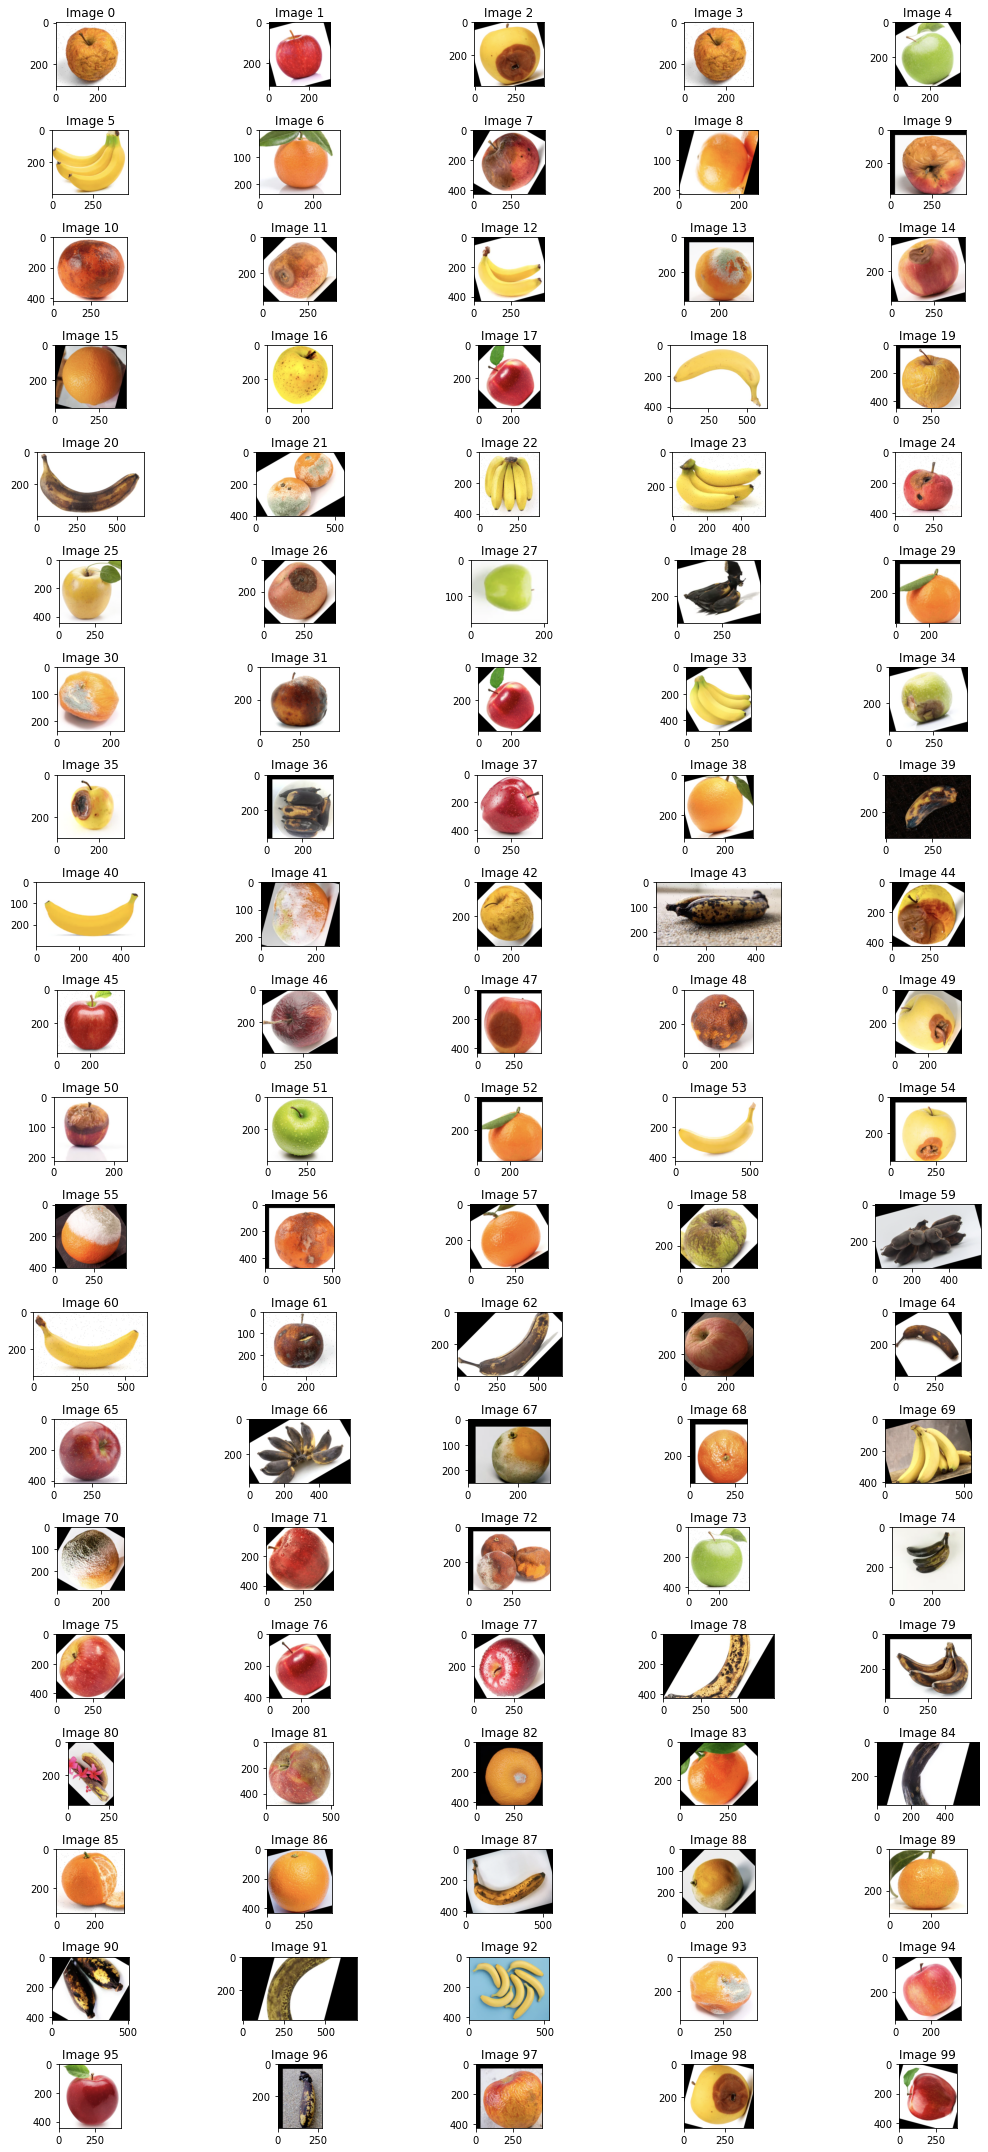

In [223]:
plotPredImgs(testImgIndex)

In [224]:
CCPredResult = []
for testImg in tqdm(testImgs):
    predImg = np.expand_dims(testImg, axis=0)
    CCPredResult.append(CombineClassPredictor(predImg))

  0%|          | 0/100 [00:00<?, ?it/s]

In [225]:
printResult(CCPredResult, testResult)

img0	[Correct]	=> Predict: ['apple', 'rotten']  	|   Real: ['apple', 'rotten']
img1	[Correct]	=> Predict: ['apple', 'rotten']  	|   Real: ['apple', 'rotten']
img2	[Correct]	=> Predict: ['apple', 'rotten']  	|   Real: ['apple', 'rotten']
img3	[Correct]	=> Predict: ['banana', 'rotten']  	|   Real: ['banana', 'rotten']
img4	[Correct]	=> Predict: ['orange', 'fresh']  	|   Real: ['orange', 'fresh']
img5	[Correct]	=> Predict: ['orange', 'rotten']  	|   Real: ['orange', 'rotten']
img6	[Correct]	=> Predict: ['orange', 'fresh']  	|   Real: ['orange', 'fresh']
img7	[Correct]	=> Predict: ['apple', 'rotten']  	|   Real: ['apple', 'rotten']
img8	[Correct]	=> Predict: ['banana', 'fresh']  	|   Real: ['banana', 'fresh']
img9	[Correct]	=> Predict: ['banana', 'rotten']  	|   Real: ['banana', 'rotten']
img10	[Correct]	=> Predict: ['apple', 'rotten']  	|   Real: ['apple', 'rotten']
img11	[Correct]	=> Predict: ['orange', 'rotten']  	|   Real: ['orange', 'rotten']
img12	[Correct]	=> Predict: ['orange', 'ro